In [1]:
import os
import numpy as np
import pandas as pd
from pyvis.network import Network
import seaborn as sns

/var/folders/q4/ywlg60x9791g_364np64pv6m0000gn/T/ipykernel_22797/851524594.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# set GOI

GOI = 'VAV3'

In [5]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

f_adj = "SCENICfiles/adj.csv"

In [6]:
net = Network(notebook=True, select_menu=True, cdn_resources='remote', height='750px', width='100%', bgcolor="#222222", font_color="white")
net.barnes_hut(gravity=-4000, central_gravity=1)

In [7]:
def clean_target_genes(row):
    return eval(row['TargetGenes'])

In [8]:
adjacencies = pd.read_csv(os.path.join(wdir, f_adj))
regulon = pd.read_csv(os.path.join(wdir, "SCENICfiles/reg.csv"))
regulon.apply(clean_target_genes, axis=1)

0       [(SNAPC1, 0.3106342842966851), (MCOLN1, 0.5420...
1       [(KIAA1328, 0.3970861519089653), (FANCL, 0.461...
2       [(C17orf97, 0.3100105285841538), (DACT2, 0.425...
3       [(SENP8, 0.7902819247600439), (SPDEF, 0.367617...
4       [(KTN1, 0.4799956278331701), (PHF3, 0.58684373...
                              ...                        
3367    [(TRIM26, 0.1201918626925179), (PGM5, 0.232152...
3368    [(RNF146, 0.2550295040430109), (COL16A1, 0.382...
3369    [(SLCO2B1, 0.3591370907224389), (NRXN2, 0.1067...
3370    [(ETV3, 0.103677774272525), (FAAP100, 0.473556...
3371    [(ZFYVE27, 0.1691535174831882), (OSER1, 0.0855...
Length: 3372, dtype: object

In [82]:
# find all regulons that have GOI (CASP8) in their target genes
def find_regulons(df, GOI):
    goi_regulons = regulon[regulon['TargetGenes'].str.contains(str(GOI+'\''))]
    return goi_regulons['TF'].values

def make_regulon_dataframe(TF):
    reg_df = pd.DataFrame()
    for i in regulon[regulon['TF'] == TF]['TargetGenes']:
        temp = eval(i)
        reg_df = pd.concat([reg_df, pd.DataFrame(temp)], axis=0)
    reg_df = reg_df.reset_index(drop=True)
    reg_df = reg_df.drop_duplicates()
    reg_df['TF'] = TF
    reg_df = reg_df.rename(columns={0: 'target', 1: 'importance', 2: 'TF'})
    reg_df = reg_df.sort_values(by='importance', ascending=False)
    reg_df = reg_df.head(500) # keep top 100ish here? supported by motif analysis
    reg_df['group'] = str(TF + "_regulon")
    return reg_df

def make_adj_df(GOI): # question is if we even want the adjacencies in the netowork? 
    adj_interest = adjacencies[adjacencies['target'] == GOI]
    adj_interest = adj_interest.sort_values(by='importance', ascending=False)
    adj_interest = adj_interest.head(15) # select top n 'important' TFs, threshold can be adjusted
    adj_interest['group'] = 'adjacencies'
    return adj_interest

In [83]:
def make_goi_grn(GOI):
    goi_regulons = find_regulons(regulon, GOI)
    goi_grn = pd.DataFrame()
    for i in goi_regulons:
        goi_grn = pd.concat([goi_grn, make_regulon_dataframe(i)], axis=0)
    #goi_grn = pd.concat([goi_grn, make_adj_df(GOI)], axis=0)
    return goi_grn

In [84]:
goi_grn = make_goi_grn(GOI)
goi_grn.drop_duplicates(subset=['importance', 'TF', 'group'], keep="first", inplace=True)
goi_grn = goi_grn.sort_values(by='importance', ascending=False)
goi_grn = goi_grn[goi_grn.duplicated(subset=['target'], keep=False)] # drop singletons
len(goi_grn)

1508

<Axes: xlabel='importance', ylabel='Count'>

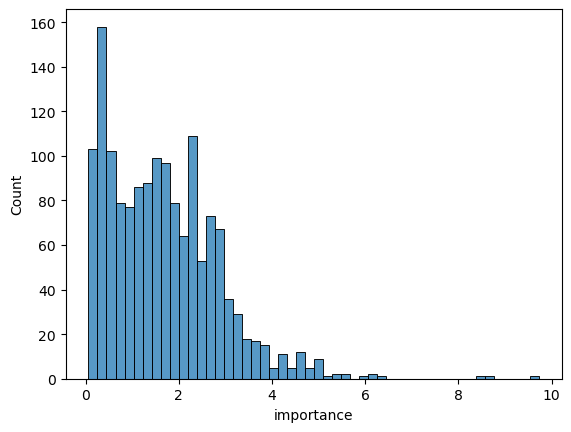

In [85]:
# visualize distribution of importance scores
sns.histplot(goi_grn['importance'], kde=False, bins=50)

In [86]:
# all regulons that have GOI in their target genes
goi_grn[goi_grn['target'] == GOI]

,target,importance,TF,group
593,VAV3,2.708242,KLF5,KLF5_regulon
662,VAV3,1.036355,CDX2,CDX2_regulon
51,VAV3,0.346808,ZBTB7A,ZBTB7A_regulon
25,VAV3,0.063045,ERF,ERF_regulon


In [91]:
# print short summary of GOI and each regulon
# import gene summary data from NCBI using BioPython

import time
import xmltodict
from collections import defaultdict
from Bio import Entrez


def get_entrez_gene_summary(
    gene_name, email, organism="human", max_gene_ids=100
):
    """Returns the 'Summary' contents for provided input
    gene from the Entrez Gene database. 
    
    Args:
        gene_name (string): Official (HGNC) gene name 
           (e.g., 'KAT2A')
        email (string): Required email for making requests
        organism (string, optional): defaults to human. 
           Filters results only to match organism. Set to None
           to return all organism unfiltered.
        max_gene_ids (int, optional): Sets the number of Gene
           ID results to return (absolute max allowed is 10K).
        
    Returns:
        dict: Summaries for all gene IDs associated with 
           gene_name (where: keys → [orgn][gene name],
                      values → gene summary)
    """
    Entrez.email = email

    query = (
        f"{gene_name}[Gene Name]"
        if not organism
        else f"({gene_name}[Gene Name]) AND {organism}[Organism]"
    )
    handle = Entrez.esearch(db="gene", term=query, retmax=max_gene_ids)
    record = Entrez.read(handle)
    handle.close()

    gene_summaries = defaultdict(dict)
    gene_ids = record["IdList"]

    #print(f"{len(gene_ids)} gene IDs returned associated with gene {gene_name}.")

    for gene_id in gene_ids:
        #print(f"\tRetrieving summary for {gene_id}...")
        handle = Entrez.efetch(db="gene", id=gene_id, rettype="docsum")
        gene_dict = xmltodict.parse(
            "".join([x.decode(encoding="utf-8") for x in handle.readlines()]),
            dict_constructor=dict,
        )
        gene_docsum = gene_dict["eSummaryResult"]["DocumentSummarySet"][
            "DocumentSummary"
        ]
        name = gene_docsum.get("Name")
        summary = gene_docsum.get("Summary")
        gene_organism = gene_docsum.get("Organism")["CommonName"]
        gene_summaries[gene_organism][name] = summary
        handle.close()
        time.sleep(0.34)  # Requests to NCBI are rate limited to 3 per second

    return gene_summaries


# method to format gene summary from NCBI to print readably
def format_gene_summary(gene_summary):
    i = 0
    for gene_name, summary in gene_summary.items():
        if i == 0:
            # skip the first gene summary
            i += 1
            continue
        print(f"\n{gene_name}: \n")
        text = summary
        # split gene summary text into separate strings after each 10th white space
        n = 12
        groups = text.split(' ')
        text = [' '.join(groups[i:i+n]) for i in range(0, len(groups), n)]
        for t in text:
            print(f"\t{t}")



email = 'samanthabening@live.com'
gene_summaries = {'Gene': 'Summary'}

for gene in ([GOI] + goi_grn[goi_grn['target'] == GOI]['TF'].unique().tolist()):
    gene_summaries[gene] = get_entrez_gene_summary(gene, email)['human'][gene]

In [88]:
# assign colors to regulons
groups = {}
colors = sns.color_palette("Set2", len(goi_grn['group'].unique())).as_hex()
i = 0
for group in goi_grn['group'].unique():
    groups[group] = colors[i]
    i = i + 1

In [89]:
# build network

sources = goi_grn['TF']
targets = goi_grn['target']
weights = goi_grn['importance']
group = goi_grn['group']

edge_data = zip(sources, targets, weights, group)

for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                net.add_node(src, src, title=src, color=groups[e[3]])
                net.add_node(dst, dst, title=dst, color=groups[e[3]])
                net.add_edge(src, dst, value=w, color=groups[e[3]])

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
                node["title"] = node['id']
                node["value"] = len(neighbor_map[node["id"]])
                node['label'] = node['id']

# Summary of GRN Data

In [ ]:
# TODO: summary of GOI and its regulons

In [92]:
# Biological summary of GOI and its (direct) regulons
format_gene_summary(gene_summaries)


VAV3: 

	This gene is a member of the VAV gene family. The VAV
	proteins are guanine nucleotide exchange factors (GEFs) for Rho family GTPases that
	activate pathways leading to actin cytoskeletal rearrangements and transcriptional alterations. This gene
	product acts as a GEF preferentially for RhoG, RhoA, and to a
	lesser extent, RAC1, and it associates maximally with the nucleotide-free states of
	these GTPases. Alternatively spliced transcript variants encoding different isoforms have been described
	for this gene. [provided by RefSeq, Jul 2008]

KLF5: 

	This gene encodes a member of the Kruppel-like factor subfamily of zinc
	finger proteins. The encoded protein is a transcriptional activator that binds directly
	to a specific recognition motif in the promoters of target genes. This
	protein acts downstream of multiple different signaling pathways and is regulated by
	post-translational modification. It may participate in both promoting and suppressing cell proliferation.
	Expres

# Network Visualization

In [29]:
net.show_buttons(filter_=['physics'])
net.show("src/goi_network.html")